In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.

In [2]:
from torch.utils.data import Dataset
import random

In [3]:
# GPU사용 설정

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla V100-PCIE-32GB


device(type='cuda')

In [4]:
# GPU 할당 변경하기
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  1
Tesla V100-PCIE-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [5]:
class MnistDataset(Dataset):
    def __init__(self, csv_file):
        self.data_df = pd.read_csv(csv_file, header=None)
        
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index, 0]
        target = torch.zeros((10))
        target[label] = 1.0
        
        image_values = torch.Tensor(self.data_df.iloc[index, 1:].values)/255.0
        
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
        plt.title(f"label= {self.data_df.iloc[index, 0]}")
        plt.imshow(img, interpolation="none", cmap="Blues")
        

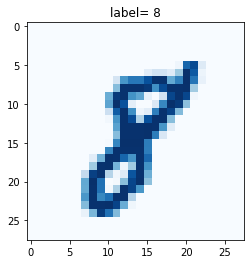

In [6]:
mnist_dataset = MnistDataset("./myo_gan/mnist_train.csv")
mnist_dataset.plot_image(17)

In [27]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(784, 200),
                                   nn.LeakyReLU(0.02),
                                   nn.LayerNorm(200),
                                   nn.Linear(200, 1),
                                   nn.Sigmoid()
                                  )
        self.model = self.model.cuda()
        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
        self.outputs = 0
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        self.outputs = self.forward(inputs)
        
        loss = self.loss_function(self.outputs, targets)
        
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        
        if (self.counter % 1000000 == 0):
            print(f"counter = {self.counter}")
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", 
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [8]:
def generate_random_image(size):
    return torch.rand(size)

In [9]:
def generate_random_seed(size):
    return torch.randn(size)

In [12]:
D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    # 숫자 이미지는 1
    D.train(image_data_tensor, torch.Tensor([1.0]))
        
    # 랜덤 이미지는 0
    D.train(generate_random_seed(784), torch.Tensor([0.0]))
    

counter = 10000
counter = 20000
counter = 30000
counter = 40000
counter = 50000
counter = 60000
counter = 70000
counter = 80000
counter = 90000
counter = 100000
counter = 110000
counter = 120000


In [13]:
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
    print( D.forward( image_data_tensor ).item() )
    pass

for i in range(4):
    print( D.forward( generate_random_image(784) ).item() )
    pass

0.9999817609786987
0.9999831914901733
0.9999580383300781
0.9999834299087524
0.9999734163284302
0.9999749660491943
0.9999740123748779
0.9999706745147705


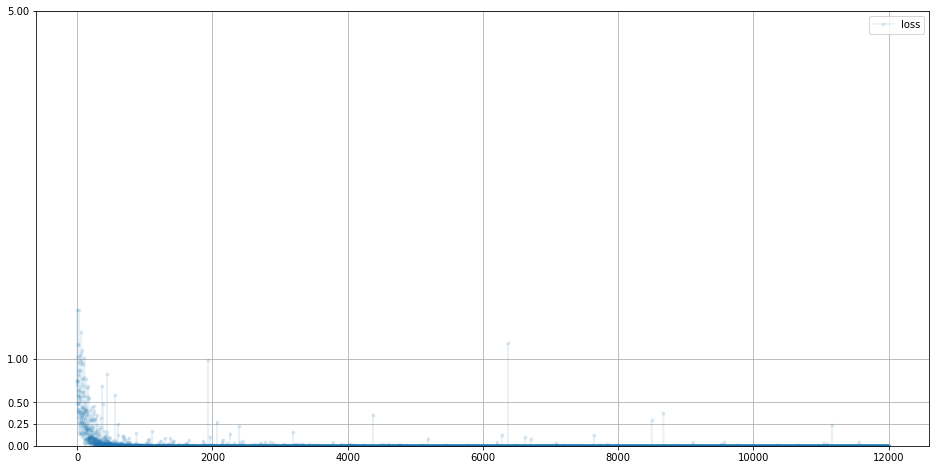

In [14]:
D.plot_progress()

In [15]:
for i in range(4):
    image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
    print(D.forward(image_data_tensor).item())

0.9999804496765137
0.9999639987945557
0.9999827146530151
0.9999816417694092


In [16]:
for i in range(4):
    print(D.forward(generate_random_image(784)).item())

0.999968409538269
0.999966025352478
0.9999738931655884
0.9999743700027466


In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(nn.Linear(100, 200), 
                                   nn.LeakyReLU(0.02),
                                   nn.LayerNorm(200),
                                   nn.Linear(200, 784),
                                   nn.Sigmoid()
                                  )
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        
        d_output = D.forward(g_output)
        
        loss = D.loss_function(d_output, targets)
        
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=["loss"])
        df.plot(ylim=(0), figsize=(16, 8), alpha=0.1, marker=".", 
                grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

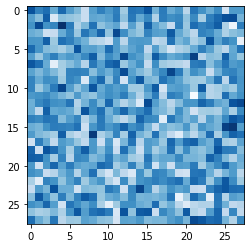

In [18]:
G = Generator()
output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy().reshape(28, 28)
plt.imshow(img, cmap="Blues")

In [32]:
%%time

D = Discriminator()
G = Generator()

epochs = 400
for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    for label, image_data_tensor, target_tensor in mnist_dataset:

        # 참에 대해 판별기 훈련
        D.train(image_data_tensor, torch.Tensor([1.0]))

        # 거짓에 대해 판별기 훈련
        D.train(G.forward(generate_random_seed(100)).detach(), torch.Tensor([0.0]))

        # 생성기 훈련
        G.train(D, generate_random_seed(100), torch.Tensor([1.0]))

epoch =  1
epoch =  2
epoch =  3
epoch =  4
epoch =  5
epoch =  6
epoch =  7
epoch =  8
epoch =  9
counter = 1000000
epoch =  10
epoch =  11
epoch =  12
epoch =  13
epoch =  14
epoch =  15
epoch =  16
epoch =  17
counter = 2000000
epoch =  18
epoch =  19
epoch =  20
epoch =  21
epoch =  22
epoch =  23
epoch =  24
epoch =  25
counter = 3000000
epoch =  26
epoch =  27
epoch =  28
epoch =  29
epoch =  30
epoch =  31
epoch =  32
epoch =  33
epoch =  34
counter = 4000000
epoch =  35
epoch =  36
epoch =  37
epoch =  38
epoch =  39
epoch =  40
epoch =  41
epoch =  42
counter = 5000000
epoch =  43
epoch =  44
epoch =  45
epoch =  46
epoch =  47
epoch =  48
epoch =  49
epoch =  50
counter = 6000000
epoch =  51
epoch =  52
epoch =  53
epoch =  54
epoch =  55
epoch =  56
epoch =  57
epoch =  58
epoch =  59
counter = 7000000
epoch =  60
epoch =  61
epoch =  62
epoch =  63
epoch =  64
epoch =  65
epoch =  66
epoch =  67
counter = 8000000
epoch =  68
epoch =  69
epoch =  70
epoch =  71
epoch =  72
e

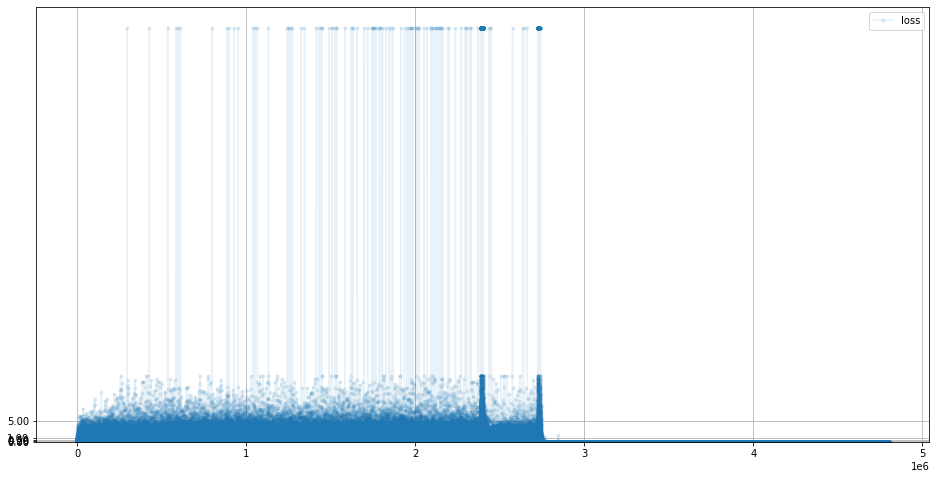

In [33]:
D.plot_progress()

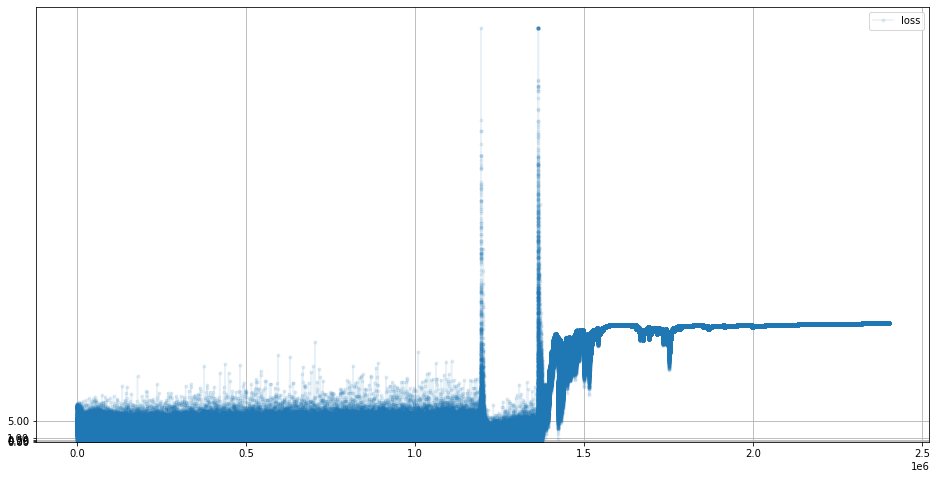

In [34]:
G.plot_progress()

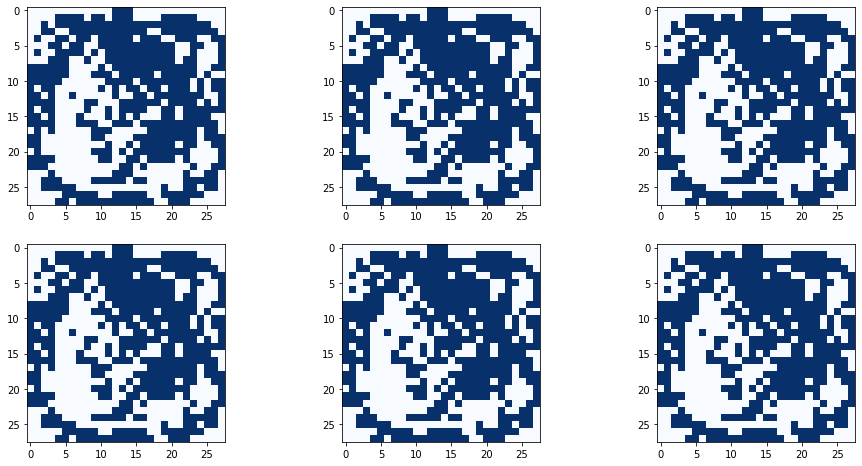

In [35]:
f, axes = plt.subplots(2, 3, figsize=(16, 8))
axs = axes.ravel()

for ax in axs:
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy().reshape(28, 28)
    ax.imshow(img, cmap="Blues")